In [1]:
%reset -fs

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers


In [5]:
cb_training = image_dataset_from_directory('mstar_imgs',
                                           subset='training',
                                           image_size=(128, 128),
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale')

cb_validation = image_dataset_from_directory('mstar_imgs',
                                           subset='validation',
                                           image_size=(128, 128),
                                           labels='inferred',
                                           validation_split=.2,
                                           seed=10,
                                           label_mode='categorical',
                                           color_mode='grayscale')

Found 10595 files belonging to 9 classes.
Using 8476 files for training.
Found 10595 files belonging to 9 classes.
Using 2119 files for validation.


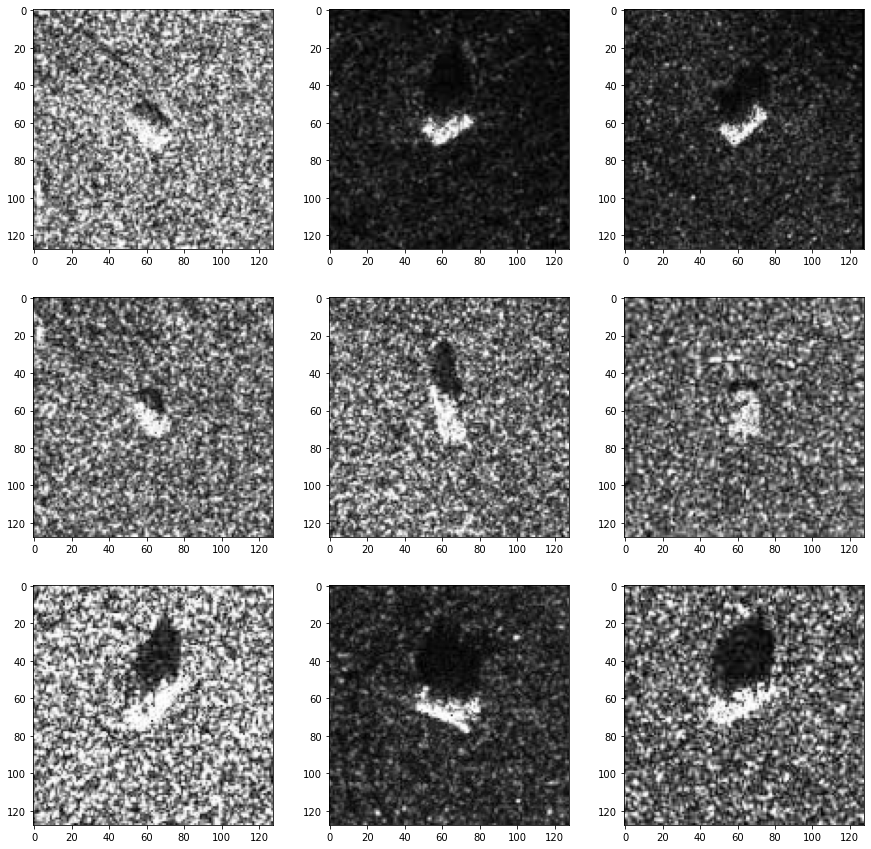

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for images, labels in cb_training.take(1):
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i].numpy().astype('uint8'), cmap='gray')

In [ ]:
model = keras.Sequential()

model.add(layers.InputLayer(input_shape=(128, 128, 3)))

model.add(layers.Flatten())

model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

model.add(layers.Dense(9, activation='softmax'))

model.summary()

In [ ]:
metrics = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]


In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=metrics)

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_recall', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
history = model.fit(cb_training, epochs=EPOCHS, validation_data=cb_validation, batch_size=BATCH_SIZE, callbacks=[early_stopping])